In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

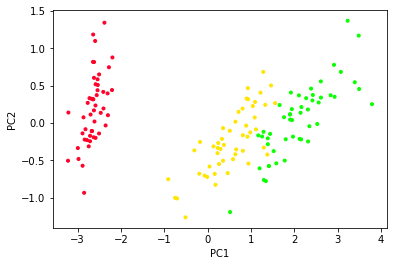

In [3]:
# load (or simulate) data
simulate = False
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    
    # run PCA
    pca_fit = PCA()
    pca_fit.fit(features)
    pc_features = pca_fit.transform(features)
    
    # plot
    fig1 = plt.figure(1)
    fig = fig1.add_subplot(111)
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')
    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 3
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.4)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')

# Set up the model

In [4]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(2.0)
#prior_params['alpha'].set(2.0)
#prior_params['alpha'].set(1.0)

prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [5]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [6]:
# run k-means init
n_kmeans_init = 50
init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [7]:
t0 = time.time()
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(init_global_free_param)
t_newton = time.time() - t0

assert converged
print('Done. Converged: ', converged)

Iter: 0	 RMSE: 5.4171664084976205	 Objective: 4834.222105876296
Iter: 50	 RMSE: 12.419820246774433	 Objective: -303.3394988457725
Iter: 100	 RMSE: 12.414977545760493	 Objective: -324.9777296376489
Iter: 150	 RMSE: 12.415510840283805	 Objective: -325.6558327124899
Iter: 200	 RMSE: 12.39831132345162	 Objective: -326.25328642359455
Iter: 250	 RMSE: 12.408615025580568	 Objective: -326.2743626124641
Iter: 300	 RMSE: 12.387215970485899	 Objective: -326.32718894128743
Optimization terminated successfully.
         Current function value: -326.337936
         Iterations: 310
         Function evaluations: 336
         Gradient evaluations: 336
Iter: 336	 RMSE: 12.390811041892476	 Objective: -326.3379360561102
Iter: 337	 RMSE: 12.390811053938076	 Objective: -326.3379360561126
Optimization terminated successfully.
         Current function value: -326.337936
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  

In [8]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [9]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [10]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

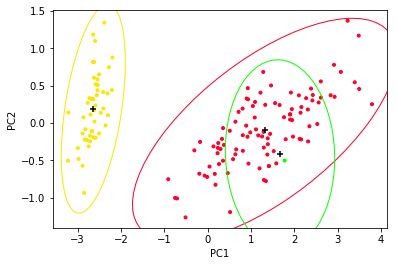

In [11]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [14]:
# save model

fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
base_alpha = model.prior_params['alpha'].get()
filename = 'bnp_full_data_fit_alpha{}_{}_.json'.format(base_alpha, dataset_name)
json_output_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)
print('saving fit dict to ', json_output_file)
with open(json_output_file, 'w') as outfile:
    json.dump(fit_dict, outfile)


saving fit dict to  ../../../../BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha2.0_iris_.json


In [15]:
# alpha_vec = np.arange()
alpha_vec = np.array([3.5])
print(alpha_vec)

[3.5]


In [16]:
# Fit multiple models and save them: 

for i in range(len(alpha_vec)): 
    if alpha_vec[i] == 8.0: 
        continue 
        
    # define prior
    prior_params = gmm_utils.get_default_prior_params(dim)
    prior_params['alpha'].set(alpha_vec[i])
    #prior_params['alpha'].set(2.0)
    #prior_params['alpha'].set(1.0)

    prior_params['prior_gamma_df'].set(8)
    prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

    # define model 
    k_approx = 12
    gh_deg = 8
    model = gmm_utils.DPGaussianMixture(
        features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

    # run k-means init
#     n_kmeans_init = 50
#     init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
    init_global_free_param = deepcopy(best_param)

    # fit model
    t0 = time.time()
    best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        model.optimize_full(init_global_free_param)
    t_newton = time.time() - t0

    assert converged
    print('Done. Converged: ', converged)

    # get KL
    kl_hessian = model.objective.fun_free_hessian(best_param)

    # save model
    fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
    base_alpha = model.prior_params['alpha'].get()
    filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(base_alpha, dataset_name)
    json_output_file = os.path.join(
        git_repo,
        'BNP_sensitivity/GMM_clustering/iris_fits/',
        filename)
    print('saving fit dict to ', json_output_file)
    with open(json_output_file, 'w') as outfile:
        json.dump(fit_dict, outfile)


Iter: 0	 RMSE: 11.265426497938217	 Objective: -319.4464262327703
Iter: 50	 RMSE: 11.278566238863462	 Objective: -320.35524499827136
Iter: 100	 RMSE: 11.277199624545311	 Objective: -320.3713331679355
Optimization terminated successfully.
         Current function value: -320.371335
         Iterations: 95
         Function evaluations: 115
         Gradient evaluations: 115
Iter: 115	 RMSE: 11.277174468698764	 Objective: -320.3713348148305
Iter: 116	 RMSE: 11.27717426956299	 Objective: -320.371334815834
Optimization terminated successfully.
         Current function value: -320.371335
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
saving fit dict to  ../../../../BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha3.5_iris.json


In [15]:
model.k_approx

12

In [19]:
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha20.0_iris.json')
# json_input_file = os.path.join(
#     git_repo,
#    'BNP_sensitivity/GMM_clustering/iris_fits/',
#    filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

moment_model = gmm_utils.InterestingMoments(model)


In [20]:
print('predicted expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

predicted expected number of clusters:  9.016361547371204
